In [1]:
using PyPlot, Printf, DelimitedFiles, Statistics
using CuArrays;
using Revise;
using MDToolbox;
PyPlot.plt.style.use("seaborn-colorblind");
ENV["COLUMNS"] = 110; #display width for MDToolbox

┌ Warning: no Manifest.toml file found, static paths used
└ @ Revise /opt/julia_depot/packages/Revise/C272c/src/Revise.jl:1219
┌ Info: Precompiling MDToolbox [7965e2f0-a35b-11e8-0207-19c030dd2def]
└ @ Base loading.jl:1260


In [2]:
KBT = KB_kcalpermol*300.0;
K = 16;
spring_constant = 50.0;

In [3]:
# read dihedral angle data
data_k = []
for k = 1:K
  filename = @sprintf "data/string_alad/10_crd_convert/umb.%d.dat" k
  x = readdlm(filename);
  push!(data_k, x)
end

filename = @sprintf "data/string_alad/10_crd_convert/umb_center.dat"
x = readdlm(filename);
umbrella_center =  x;

In [4]:
gpu_data_k = CuArray.(data_k);
gpu_umbrella_center = CuArray(umbrella_center);

## delta pmf between the umbrella snapshots and the 1st snapshot

In [5]:
CuArrays.@time delta_pmf = sp_delta_pmf(gpu_umbrella_center, gpu_data_k, KBT, spring_constant);

┌ Warning: Performing scalar operations on GPU arrays: This is very slow, consider disallowing these operations with `allowscalar(false)`
└ @ GPUArrays /opt/julia_depot/packages/GPUArrays/QDGmr/src/host/indexing.jl:43


 14.298218 seconds (24.89 M CPU allocations: 1.228 GiB, 3.78% gc time) (322 GPU allocations: 23.112 MiB, 0.40% gc time of which 36.03% spent allocating)


## design matrix for linear regression

delta_pmf = M * weight

In [6]:
sigma_rdf = 0.5;
CuArrays.@time M = sp_design_matrix_xyz(gpu_umbrella_center, gpu_data_k, sigma_rdf);

  2.297450 seconds (5.11 M CPU allocations: 246.622 MiB, 3.54% gc time) (4.61 k GPU allocations: 160.266 MiB, 5.89% gc time of which 95.44% spent allocating)


## lasso

Solve weights for 

delta_pmf = M * weight

In [7]:
M_standardized, mean_M, std_M = sp_standardize(M);
delta_pmf_vector = delta_pmf[:] .- mean(delta_pmf);

In [8]:
lambda = 0.1;
CuArrays.@time weight = sp_admm(delta_pmf_vector, M_standardized, lambda);

[ Cycle Count = 7927 ]
[ Complete Condition ]
  Max Differ = 9.998253801324353e-6


  6.086341 seconds (14.05 M CPU allocations: 635.980 MiB, 3.59% gc time) (31.72 k GPU allocations: 41.560 MiB, 7.54% gc time of which 85.81% spent allocating)


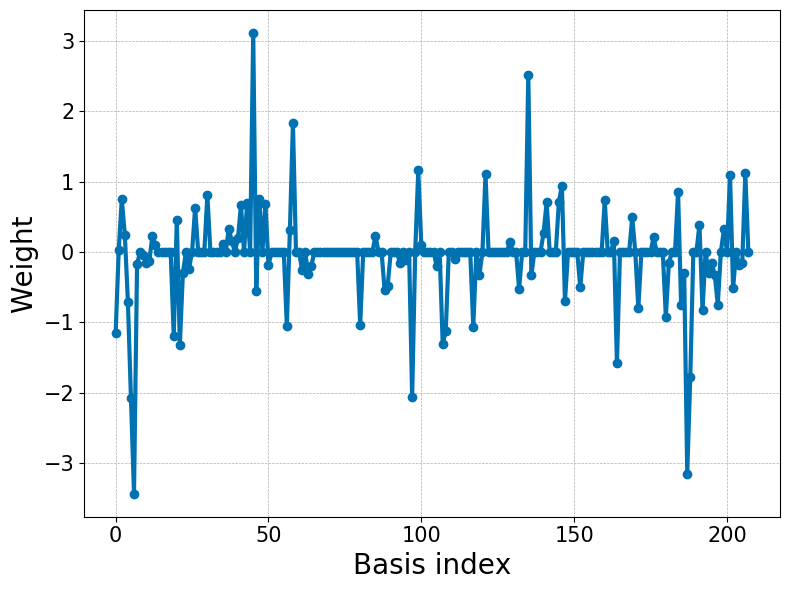

In [9]:
fig, ax = subplots(figsize=(8, 6))
ax.plot(weight[:], linewidth=3, "-o")
xlabel("Basis index",fontsize=20)
ylabel("Weight",fontsize=20)

#ax.set(xlim=[-1, 60], ylim=[-0.3, 0.3])
ax.grid(linestyle="--", linewidth=0.5)
ax.xaxis.set_tick_params(which="major",labelsize=15)
ax.yaxis.set_tick_params(which="major",labelsize=15)
ax.grid(linestyle="--", linewidth=0.5)
tight_layout()

#savefig("lasso_along_path_weight.png", dpi=350)

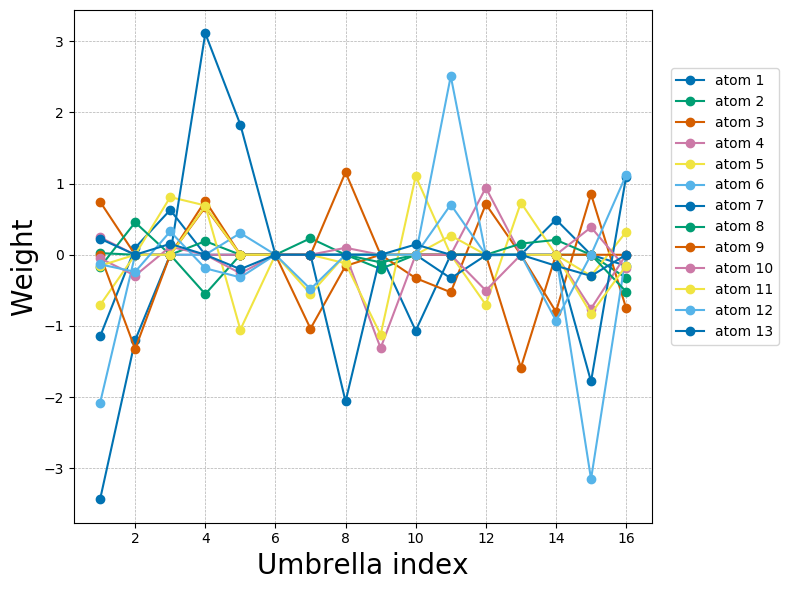

In [10]:
natom = Int(size(umbrella_center, 2) / 3)
weight_atom = reshape(weight, natom, K)'

fig, ax = subplots(figsize=(8, 6))
for iatom = 1:natom
    ax.plot(1:K, weight_atom[:, iatom], "-o", label=@sprintf "atom %d" iatom)
end
plt.xlabel("Umbrella index", fontsize=20)
plt.ylabel("Weight", fontsize=20)
plt.legend(loc="uppper right", bbox_to_anchor=(1.02, 0.9))

ax.grid(linestyle="--", linewidth=0.5)
tight_layout()

#c = get_cmap("viridis")
#c = get_cmap("tab20")

#savefig("lasso_along_path_weight_atom.png", dpi=350)

## cumulate PMF

In [11]:
pmf = sp_cumulate_pmf_atom(umbrella_center, weight, umbrella_center, sigma_rdf, mean_M, std_M)

16-element Array{Float64,1}:
  3.231225331449764
  0.0
  2.1924850037379713
  4.303603751776109
  5.7050469662331835
  6.247324225738581
  7.256309647472548
  9.037279097633359
 10.835733711110976
 12.867586801043942
 14.85666960423211
 15.597768788922295
 13.772178875439053
  9.696463155927873
  7.229199457805009
  6.764785225280477

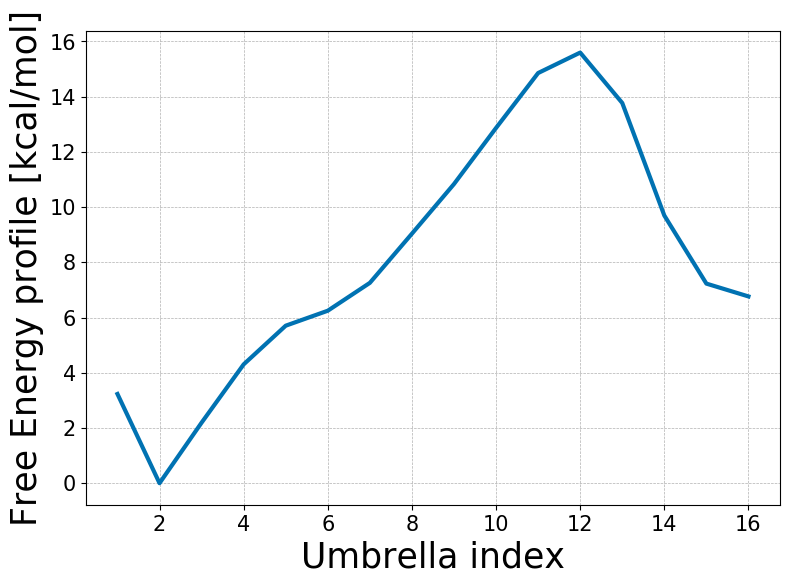

In [12]:
fig, ax = subplots(figsize=(8, 6))
ax.plot(1:K, pmf, linewidth=3)
xlabel("Umbrella index",fontsize=25)
ylabel("Free Energy profile [kcal/mol]",fontsize=25)

ax.grid(linestyle="--", linewidth=0.5)
ax.xaxis.set_tick_params(which="major",labelsize=15)
ax.yaxis.set_tick_params(which="major",labelsize=15)
ax.grid(linestyle="--", linewidth=0.5)
tight_layout()

#savefig("lasso_along_path_pmf..png", dpi=350)